## Water balance model

This notebook explains how to create a water balance model for a farm dam (a tiny lake) in Australia. We use the measurements in an Excel file. The figure below is a schematic representation of our water balance model. There are three fluxes: precipitation, evaporation and infiltration. The infiltration flux represents the flow of water from the lake to the groundwater. Inflow and outflow through the dam inlet and outlet are zero for the selected time period.

<p align="center">
<img src="water_balance.png" alt="drawing" width="600">
</p>

In [1]:
# import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read the data from excel using pandas
df = pd.read_excel('data/water_balance_data.xlsx',
                   index_col=0,
                   parse_dates=True)
df.head()

,temperature,rh,rain,wl,volume,area,vpd,evaporation,Cl_sample,delta_18O_sample,delta_2H_sample
2013-08-25,11.25,81.0,0.0,-0.481333,1188.982978,1309.122275,0.253591,4.483474,20.401982,-4.32923,-16.581998
2013-08-26,10.75,89.5,0.4,-0.491695,1175.444157,1302.024401,0.135561,2.744956,NaN,NaN,NaN
2013-08-27,13.75,71.0,0.0,-0.498408,1166.708590,1297.418221,0.456128,4.896925,NaN,NaN,NaN
2013-08-28,14.00,83.0,0.0,-0.505052,1158.090844,1292.853550,0.271763,0.594952,NaN,NaN,NaN
2013-08-29,14.10,84.5,6.8,-0.505966,1156.907482,1292.225131,0.249396,2.668875,NaN,NaN,NaN


### Precipitation

We start with calculating the volumetric flow rate of rainfall which is

$ P = P_{mm} / 1000 * A$

in which $P$ is the amount of rainfall added to the farm dam in m $^3$ /d, $P_{mm}$ the recorded daily rainfall in mm and $A$ is the water surface area m $^2$. Let's plot the required data.

<Axes: >

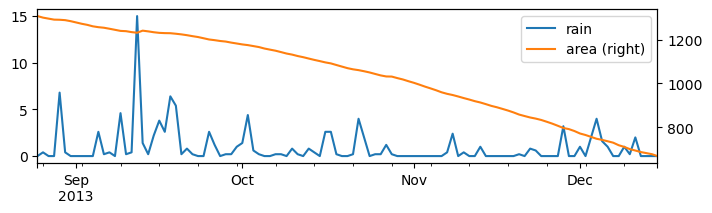

In [3]:
df[['rain', 'area']].plot(secondary_y='area', figsize=(8,2))

As a first approach, we'll use a `for` loop to get the rain flux for each daily time step.

In [4]:
P = np.zeros(len(df))           # create an array with zeros and the same size as 'df'
for i in range(len(df)):
    P[i] = df['area'].iloc[i] * df['rain'].iloc[i] / 1000.0 
df['P'] = P               # create new column in the DataFrame with the rain in m3/d

Now that we have the daily volumetric rainfall amount as a column in the DataFrame we can easily plot it.

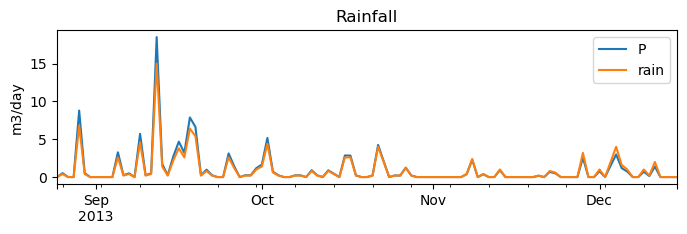

In [11]:
df[['P', 'rain']].plot(figsize=(8,2), ylabel='m3/day', title='Rainfall');

### Evaporation
Now we calculate the evaporation contribution to the water balance. The evaporation measurements in the Excel represent daily values measured using a Class A evaporation pan. The conversion to a volumetric evaporation rate in m $^3$/d is

$ E = E_{mm} / 1000 / 1.2 * A$

in which $E$ is the evaporated amount of water in m $^3$ /d, $E_{mm}$ the recorded daily pan evaporation in mm. From the equation it can be seen that the pan factor was assumed to be 1.2.

In [8]:
pan_factor = 1.2                # assuming a pan factor of 1.2
E = np.zeros(len(df))           # create an array with zeros and the same size as 'df'
for i in range(len(df)):
    E[i] = df['area'].iloc[i] * df['evaporation'].iloc[i] / 1000.0 / pan_factor 
df['E'] = E               # create new column in the DataFrame with the evaporation in m3/d

Let's plot the data

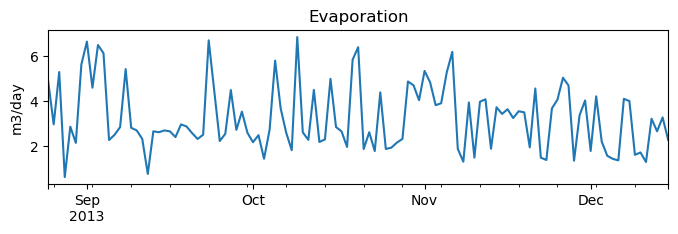

In [12]:
df['E'].plot(figsize=(8,2), ylabel='m3/day', title='Evaporation');

### Infiltration

The infiltration was not measured directly. Therefore we use the precipitation and the evaporation together with the volume changes of the farm dam to calculate the infiltration as

$ I = P - E - dV$

in which $I$ is the infiltration rate in m $^3$/d. Note that $P$ and $E$ are both positive numbers but $dV$ is negative when the water volume decreases between two consecutive days. $I$ is also a positive number when the direction of flow is from  the farm dam to the groundwater.

In [13]:
dV = np.zeros(len(df))                               # create array with volume changes in the lake
I = np.zeros(len(df))                                # create array for the infiltration
for i in range(len(df)-1):
    dV[i] =  df['volume'].iloc[i+1] - df['volume'].iloc[i]           # get change in lake volume per timestep
    I[i] = df["P"].iloc[i] - df["E"].iloc[i] - dV[i]

df['dV'] = dV                                 # create new column in the DataFrame with the Volume changes
df['I'] = I                                   # create new column in the DataFrame with the infiltration

Now we have all the water balance components we can plot the results.

<Axes: >

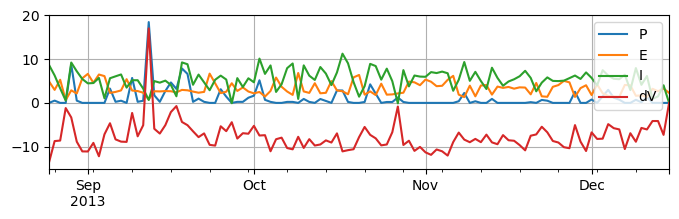

In [14]:
df[['P', 'E', 'I', 'dV']].plot(figsize=(8,2), grid=True)

## Code optimisation

The `for` loop we use to calculate the water balance components is a rather straightforward approach but it is not necissarily the fastest code. When creating model codes, it is important to pay attention to the aspect of execution time. We'll investigate this by calculating the rainfall in four different ways:
1. using the `for` loop, this is the same method as used her above
2. using a `for` loop with the iterrows function
3. using the `apply` method of a pandas DataFrame
4. using the vector operations for pandas DataFrames

We put the `%%timeit` code at the start of each cell to calculate the code execution time. This makes it easy to compare the performance of the methods. Note that the computation times can vary significantly between machines, python versions, package versions (NumPy, Pandas) and operating systems.

In [15]:
%%timeit
#1 using a simple for loop

P = np.zeros(len(df))
for i in range(len(df)):
    P[i] = df['area'].iloc[i] * df['rain'].iloc[i] / 1000.0 

df['P'] = P

1.09 ms ± 53.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
%%timeit
#2 using iterrows
df['P'] = np.nan                            # create an empty column in the dataframe with the rain 
for i, row in df.iterrows():
    P_i = row['area'] * row['rain'] / 1000.0  # calculate the rain flux for one timestap
    df.loc[i, 'P'] = P_i               # assign the value to the column in the DataFrame

7.28 ms ± 225 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
%%timeit
#3 using the apply method

# define a function to calculate the rain flux
def get_P(row):
    return row['area'] * row['rain'] / 1000.0

# apply this function to every row in a Dataframe
df['P'] = df.apply(get_P, axis=1)

875 µs ± 44.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [19]:
%%timeit
#4 using a vector operation
df['P'] = df['area'] * df['rain'] / 1000

184 µs ± 53.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


All the methods are pretty fast because our dataset is only 113 timesteps. However, you can see that there are large differences in computation times between the methods where the slowest method (1) is about 10 times slower than the fastest method (4).

We can also compare our methods using the four steps of Wes Dyer:

| method     | correct | clear | concise | fast |
|------------|---------|-------|---------|------|
| 1 for-loop | ✓       | x     | xx      | xx   |
| 2 iterrows | ✓       | x     | x       | x   |
| 3 apply    | ✓       | xx    | ✓       | x    |
| 4 vector   | ✓       | ✓✓    | ✓✓      | ✓✓    |

Note that especially 'clear' and 'concise' are very subjective criteria.

Method 4 is clearly the winner in this case. So we apply this method to the other calculations as well. We can use the `diff()` method to calculate the change in lake volume (note the minus sign that ensures that `dV` is negative when the water volume decreases in time).

In [20]:
%%timeit
df['P'] = df['area'] * df['rain'] / 1000.
df['E'] = df['area'] * df['evaporation'] / (1000. * pan_factor)
df['dV'] = -df['volume'].diff(periods=-1)
df['I'] = df['P'] - df['E'] - df['dV']

467 µs ± 18.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Can we make it even faster? By looking at the code we can see that both `df['rain']` and `df['evaporation']` are multiplied by `df['area']` and divided by 1000. We could define a variable that is equal to the area divided by 1000, and multiply the difference between rainfall and evaporation, reducing the number of arithmetic operations. Let's check if it makes a big difference. 

In [ ]:
%%timeit
f = df["area"] / 1000.
df['dV'] = -df['volume'].diff(periods=-1)
df['infiltration'] = (df['rain'] - df['evaporation'] * pan_factor) * f - df['dV']

It seems to be somewhat faster, but the code becomes a little less readable. Whether one weights up versus the other is a matter for debate.

Note that when a `for` loop can not be avoided, a significant speed-up can be achieved by converting the data to NumPy arrays. Let's have a look at the rainfall calculation once more and check the performance of the for loop but now using NumPy arrays.

In [21]:
%%timeit

rain = df['rain'].to_numpy()                # convert from a pandas dataframe to a numpy array
area = df['area'].to_numpy()                # convert from a pandas dataframe to a numpy array

P = np.zeros_like(rain)           # create an array with zeros and the same size as 'rain'
for i in range(len(P)):
    P[i] = area[i] * rain[i] / 1000.0  # calculate the rain flux for one timestap

df['P'] = P               # create new column in the DataFrame with the rain flux

71.7 µs ± 1.54 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Much faster than looping over the DataFrame! That is good news, because conceptually it is a lot easier to set up the mass balance with a `for` loop. This is because the first time step is different than the following once, plus the calulcuation of the concentration depends on the concentration in the previous time step. The code is as follows

In [22]:
pan_factor = 1.2
Cl_0 = 20 # g/m^3 = mg/l
Cl_rain = 5 # g/m^3 = mg/l

df['P'] = df['area'] * df['rain'] / 1000.
df['E'] = df['area'] * df['evaporation'] / (1000. * pan_factor)
df['dV'] = -df['volume'].diff(periods=-1)
df['I'] = df['P'] - df['E'] - df['dV']

M_Cl_g = np.empty(len(df))
conc_Cl = np.empty(len(df))

P = df["P"].to_numpy()
I = df["I"].to_numpy()
V = df["volume"].to_numpy()
for i, (Vi, Pi, Ii) in enumerate(zip(V, P, I)):
    if i == 0: # First day
        M_Cl_g[0] = Vi * Cl_0
        conc_Cl[0] = M_Cl_g[0] / Vi # Gives Cl_0 of course!
    else:
        M_Cl_g[i] = M_Cl_g[i - 1] + dM_P - dM_I
        conc_Cl[i] = M_Cl_g[i] / Vi

    dM_P = Cl_rain * Pi
    dM_I = conc_Cl[i] * Ii

df["conc_Cl"] = conc_Cl

Let's plot the calculated chloride concentrations, as well as the measured ones. The result isn't too bad, except that there appears to be a diverging trend in time. This will be dealt with in the next session.

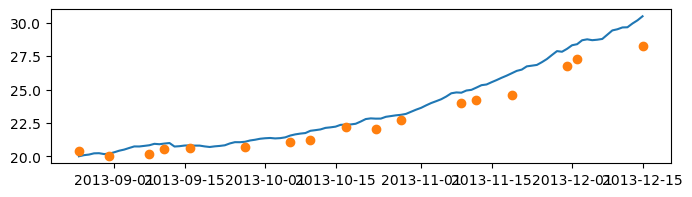

In [23]:
fig, ax = plt.subplots(figsize=(8,2))
ax.plot(df.index, df["conc_Cl"])
ax.plot(df.index, df["Cl_sample"], 'o');

For the isotopes, their removal from the dam by evaporation also needs to be considered. The calculation of the delta value of the evaporating water vapour is quite involved and has been organised in a `class` in the file `isotopes.py`. The class is called `Isotope` and is imported at the start of the code cell. The calculation procedure is the same as for chloride, except that the evaporation $E$ is now also a component that needs to be considered in the mass balance. Note how the isotope delta value of the evaporating water vapour is calculated using the `delta_e` method of the `Isotope` class.

In [26]:
from isotopes import Isotope

P = df["P"].to_numpy()
I = df["I"].to_numpy()
E = df["E"].to_numpy()
V = df["volume"].to_numpy()
Tc = df["temperature"].to_numpy()
RH = df["rh"].to_numpy() / 100.

O18 = Isotope("18O")
delta_18O_0 = -3.75
delta_18O_rain = -3.75
delta_18O_atm = -19

M_18O = np.empty(len(df))
delta_18O = np.empty(len(df))

for i, (Vi, Pi, Ei, Ii, Tci, RHi) in enumerate(zip(V, P, E, I, Tc, RH)):
    if i == 0: # First day
        M_18O[0] = Vi * delta_18O_0
        delta_18O[0] = M_18O[0] / Vi # Gives delta_18O_0 of course!
    else:
        M_18O[i] = M_18O[i - 1] + dM_P -dM_E - dM_I
        delta_18O[i] = M_18O[i] / Vi    

    dM_P = delta_18O_rain * Pi
    dM_E = O18.delta_e(Tci, RHi, delta_18O[i], delta_18O_atm) * Ei
    dM_I = delta_18O[i] * Ii

df["delta_18O"] = delta_18O

Let's plot the data and the samples. Again, the general trend is reproduced, but the modelled values underestimate the measured data this time. We'll look into this in the next session.

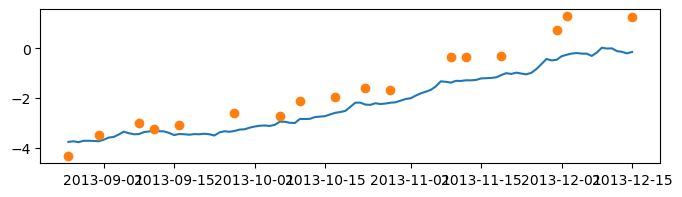

In [27]:
fig, ax = plt.subplots(figsize=(8,2))
ax.plot(df.index, df["delta_18O"])
ax.plot(df.index, df["delta_18O_sample"], 'o')

***Exercise (homework):*** Set up the mass balance for deuterium ( $^2$ H). Use the parameter values as provided in the code cell below.

In [ ]:
delta_2H_0 = -17
delta_2H_rain = -17
delta_2H_atm = -120